# 1-Librairies

In [1]:
# Dataset
import kagglehub

# Standard libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import seaborn as sns

# tensorflow libraries
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import preprocess_input

# keras libraries
from keras.optimizers import Adam

# scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

# Suppression des warnings
import warnings
warnings.filterwarnings("ignore")

# 2-Dataset

In [2]:
# Téléchargement du dataset depuis Kaggle
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Chemin d'accés du dossier du Dataset:", path)

# Classification des images de tumeurs cérébrales
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
# Affichage des noms de classes
print("Class names:", class_names)

# Convertir les noms de classes en binaire
# Ici, nous considérons 'notumor' comme 'Sain' et les autres comme 'Tumeur'
binary_class_names = ['Sain' if name == 'notumor' else 'Tumeur' for name in class_names]

# Affichage des noms de classes binaires
binary_class_names = dict(zip(class_names, binary_class_names))
print("Binary class names:", binary_class_names)

Chemin d'accés du dossier du Dataset: /kaggle/input/brain-tumor-mri-dataset
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Binary class names: {'glioma': 'Tumeur', 'meningioma': 'Tumeur', 'notumor': 'Sain', 'pituitary': 'Tumeur'}


## 2.1-Dataset Entrainement

In [3]:
# Création de train_df à partir du dossier Training
train_images = []
train_binary_class_names = []

# Parcours des images dans le dossier Training
train_dir = os.path.join(path, 'Training')
for category in binary_class_names:
	category_path = os.path.join(train_dir, category)
	for img_name in os.listdir(category_path):
		train_images.append(os.path.join(category_path, img_name))
		train_binary_class_names.append(binary_class_names[category])
# Affichage du nombre d'images dans le dataset d'entraînement
print("Nombre d'images dans le dataset d'entraînement:", len(train_images))
# Création du DataFrame train_df
train_df = pd.DataFrame({"image_path": train_images, "label": train_binary_class_names})

X_train = train_df["image_path"].values
y_train = train_df["label"].values

print("Nombre d'images par classes dans le dataset de validation:", train_df['label'].value_counts())

Nombre d'images dans le dataset d'entraînement: 5712
Nombre d'images par classes dans le dataset de validation: label
Tumeur    4117
Sain      1595
Name: count, dtype: int64


## 2.2-Dataset Test

In [4]:
# Création de test_df à partir du dossier Testing
test_images = []
test_binary_class_names = []

# Parcours des images dans le dossier Testing
test_dir = os.path.join(path, 'Testing')
for category in class_names:
	category_path = os.path.join(test_dir, category)
	for img_name in os.listdir(category_path):
		test_images.append(os.path.join(category_path, img_name))
		test_binary_class_names.append(binary_class_names[category])

# Affichage du nombre d'images dans le dataset d'entraînement
print("Nombre d'images dans le dataset d'entraînement:", len(test_images))
# Création du DataFrame train_df
test_df = pd.DataFrame({"image_path": test_images, "label": test_binary_class_names})

X_test = test_df["image_path"].values
y_test = test_df["label"].values

print("Nombre d'images par classes dans le dataset de validation:", test_df['label'].value_counts())

Nombre d'images dans le dataset d'entraînement: 1311
Nombre d'images par classes dans le dataset de validation: label
Tumeur    906
Sain      405
Name: count, dtype: int64


## 2.3-Dataset de Validation

In [5]:
# Creation d'un dataset de validation
X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"].to_numpy(),
    train_df["label"].to_numpy(),
    train_size=0.7,  # 80% des données pour l'entraînement
    test_size=0.3,   # 20% des données pour la validation
    random_state=42,
    stratify=train_df["label"],
)
val_df = pd.DataFrame({'image_path': X_val, 'label': y_val})

# Affichage du nombre d'images par classes dans le dataset de validation
print("Nombre d'images par classes dans le dataset de validation:", val_df['label'].value_counts())

Nombre d'images par classes dans le dataset de validation: label
Tumeur    1235
Sain       479
Name: count, dtype: int64


# 3-Preprocessing

## 3.1-Paramêtres

In [6]:
# Creation des hyperparamètres
def create_params():
    return {
        'batch_size': 32,  # Taille du batch
        'image_size': (128, 128),  # Taille des images pour VGG19
        'input_shape': (128, 128, 3),  # Forme d'entrée pour les images RGB
        'epochs': 20,  # Nombre d'époques pour l'entraînement
        'learning_rate': 0.001,  # Taux d'apprentissage pour l'optimiseur
    }

params = create_params()

## 3.2-ImageDataGenerator

In [7]:
# Création d'un ImageDataGenerator pour l'augmentation des données d'entraînement
def create_datagen():
    return tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,         # Retourner les images horizontalement
        rotation_range=10,            # Rotation aléatoire des images
        zoom_range=0.1,               # Zoom aléatoire des images
        width_shift_range=0.1,        # Décalage horizontal aléatoire
        height_shift_range=0.1,       # Décalage vertical aléatoire
        preprocessing_function=preprocess_input # Ajout de la fonction de prétraitement
    )

datagen = create_datagen()

## 3.3- Equilibrage du dataset d'entrainement

In [8]:
# Affichage du nombre d'images dans le DataFrame train_df
print("Nombre d'images dans le train_df:", len(train_df))
# Affichage du nombre d'images par classes dans le dataset d'entraînement
print("Nombre d'images par classes dans le dataset de train:", train_df['label'].value_counts())

Nombre d'images dans le train_df: 5712
Nombre d'images par classes dans le dataset de train: label
Tumeur    4117
Sain      1595
Name: count, dtype: int64


### 3.3.1-Séparation du label en 2 sous-classes

In [9]:
# Filtrage des images 'Sain' dans le DataFrame train_df
notumor_train_df = train_df[train_df['label'] == 'Sain']
# Filtrage des images 'Tumeur' dans le DataFrame train_df
# Ici, nous considérons 'Tumeur' comme toutes les autres classes sauf 'Sain
tumor_train_df = train_df[train_df['label'] == 'Tumeur']

# Affichage du nombre d'images dans le DataFrame filtré
print("Nombre d'images 'Sain':", len(notumor_train_df))
print("Nombre d'images 'Tumeur':", len(tumor_train_df))

Nombre d'images 'Sain': 1595
Nombre d'images 'Tumeur': 4117


### 3.3.2-Augmentation de la classe minoritaire

Nombre d'images 'Sain' dans le train_df: 1595
Nombre d'images augmentées 'Sain': 4785


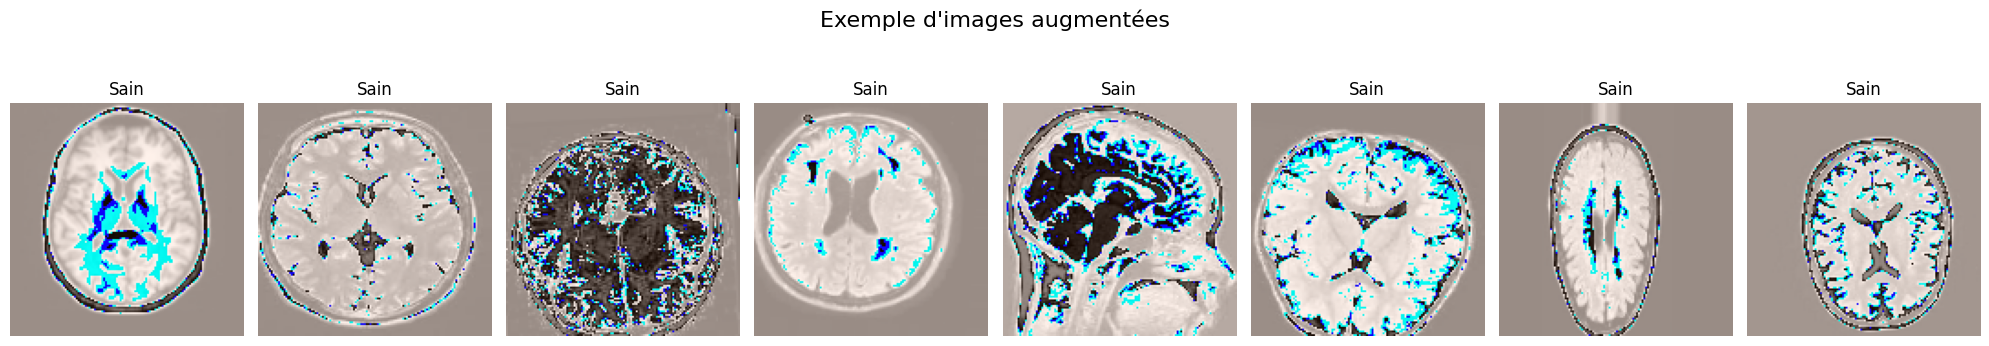

In [10]:
# Appliquer l'augmentation des données uniquement sur les images 'Sain'
notumor_train_df_datagen_images = []
#
for x in notumor_train_df['image_path'].values:
    # Charger l'image, la redimensionner et la convertir en array
    img = tf.keras.utils.load_img(x, target_size=params['image_size'])
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # nécessaire pour ImageDataGenerator
    for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
        notumor_train_df_datagen_images.append(batch[0])
        if i >= 2:  # 1 augmentations par image
            break
X_class1_aug = np.array(notumor_train_df_datagen_images)

# Affichage du nombre d'images augmentées et du DataFrame d'entrainement
print("Nombre d'images 'Sain' dans le train_df:", len(notumor_train_df))
print("Nombre d'images augmentées 'Sain':", len(X_class1_aug))

# Visualisation d'un échantillon d'images notumor (tirage aléatoire de 8 images du tableau numpy)
num_samples = 8
random_indices = np.random.choice(len(X_class1_aug), size=num_samples, replace=False)
sample_images = X_class1_aug[random_indices]

fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for j, img_array in enumerate(sample_images):
    img = img_array.astype(np.uint8)
    axes[j].imshow(img)
    axes[j].axis("off")
    axes[j].set_title("Sain", fontsize=12)
plt.suptitle("Exemple d'images augmentées", fontsize=16)
plt.tight_layout()
plt.show()


### 3.3.3-Création du dataset d'entrainement augmenté

In [11]:
# Création du dataset d'entrainement augmenté en mémoire

# Charger les images de tumeurs originales en mémoire
tumor_images_in_memory = []
for img_path in tumor_train_df['image_path'].values:
    img = tf.keras.utils.load_img(img_path, target_size=params['image_size'])
    img_array = tf.keras.utils.img_to_array(img)
    tumor_images_in_memory.append(img_array)

# Combiner les images augmentées 'Sain' avec les images 'Tumeur'
X_train_augmented = np.concatenate([np.array(tumor_images_in_memory), X_class1_aug])

# Créer les labels correspondants
tumor_labels = [1] * len(tumor_images_in_memory)  # 1 pour 'Tumeur'
notumor_labels = [0] * len(X_class1_aug)  # 0 pour 'Sain'
y_train_augmented = np.array(tumor_labels + notumor_labels)

# Mélanger les données
X_train, y_train = shuffle(X_train_augmented, y_train_augmented, random_state=42)

print("Forme de X_train après augmentation:", X_train.shape)
print("Forme de y_train après augmentation:", y_train.shape)
print("Distribution des classes dans le jeu d'entraînement augmenté:")
print(pd.Series(y_train).value_counts())

Forme de X_train après augmentation: (8902, 128, 128, 3)
Forme de y_train après augmentation: (8902,)
Distribution des classes dans le jeu d'entraînement augmenté:
0    4785
1    4117
Name: count, dtype: int64


## 3.4-Création des dataset ImageDataGenerator

In [12]:
# Le générateur d'entraînement utilise les augmentations et le prétraitement
train_augmented_datagen = datagen.flow(
    X_train,
    y_train,
    batch_size=params['batch_size']
)

# Création d'un générateur SANS augmentation pour la validation et le test,
# mais AVEC la fonction de prétraitement ResNet50.
validation_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Création du générateur pour les données de validation
val_datagen = validation_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='binary'
)

# Création du générateur pour les données de test
test_datagen = validation_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='binary',
    shuffle=False
)

Found 1714 validated image filenames belonging to 2 classes.
Found 1311 validated image filenames belonging to 2 classes.


# 4-Modèle CNN ResNet50

## 4.1- Chargement du modèle ResNet50

In [13]:
# Chargement du modèle de base
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=params['input_shape'])

# Analyse des couches de Resnet50
print("Analyse des couches de ResNet50:")
print(f"Nombre total de couches: {len(base_model.layers)}")

# Afficher quelques couches pour comprendre la structure
print("\nStructure des couches (dernières 20):")
for i, layer in enumerate(base_model.layers[-20:]):
    print(f"   {len(base_model.layers)-10+i:3d}: {layer.name} ({layer.__class__.__name__})")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Analyse des couches de ResNet50:
Nombre total de couches: 175

Structure des couches (dernières 20):
   165: conv5_block2_1_conv (Conv2D)
   166: conv5_block2_1_bn (BatchNormalization)
   167: conv5_block2_1_relu (Activation)
   168: conv5_block2_2_conv (Conv2D)
   169: conv5_block2_2_bn (BatchNormalization)
   170: conv5_block2_2_relu (Activation)
   171: conv5_block2_3_conv (Conv2D)
   172: conv5_block2_3_bn (BatchNormalization)
   173: conv5_block2_add (Add)
   174: conv5_block2_out (Activation)
   175: conv5_block3_1_conv (Conv2D)
   176: conv5_block3_1_bn (BatchNormalization)
   177: conv5_block3_1_relu (Activation)
   178: conv5_block3_2_conv (Conv2D)
   179: conv5_block3_2_bn (BatchNormalization)
   180: conv5_block3_2_relu (Activation)
   181: conv5_block3_3_conv (Conv2D)
   182: conv5_block3_3_bn (BatchNormalization)
   183: conv5_block3_add (Add)
   184: conv5_block3_out (Activation)


## 4.2- Phase 1 : Transfer Learning

### 4.2.1-Création du modèle  avec les couches gelées

In [14]:
# Gel des couches du modèle de base (Transfer Learning)
base_model.trainable = False

# Couche d'entrée
inputs = tf.keras.Input(params['input_shape'])

x = base_model(inputs, training=False) # Modèle de base gelé
# Pooling global pour réduire les dimensions
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Couche de dropout pour la régularisation
x = tf.keras.layers.Dropout(0.5)(x)
# Ajouter nouvelle couche de classification
x = tf.keras.layers.Dense(128, activation='relu')(x)  # Couche dense avec 128 neurones et activation ReLU

# Couche de sortie
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # Couche de classification finale

# Création du modèle final
model = tf.keras.Model(inputs, outputs)

### 4.2.2-Compilation du modèle avec couche gelées

In [15]:
# Compilation des modeles
def compile_model(model):
    compile_config = {
        'optimizer': Adam(learning_rate=params['learning_rate']),
        'loss': 'binary_crossentropy',  # Utilisation de 'binary_crossentropy' pour la classification binaire
        'metrics': ['accuracy', 'Precision', 'Recall']
    }
    model.compile(**compile_config)
    return model
cnn_model_resnet50 = compile_model(model)

print("\n=== ARCHITECTURE CNN - ResNet50 ===")
cnn_model_resnet50.summary()


=== ARCHITECTURE CNN - ResNet50 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 4.2.3-CallBacks

In [16]:
def create_callbacks():
    callbacks_list = [

        # Sauvegarde du meilleur modèle
        callbacks.ModelCheckpoint(
            './models/model_cnn_resnet50.keras',
            monitor='val_accuracy',
            save_best_only=True,
        ),

        # Early stopping pour éviter l'overfitting
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
        )
    ]
    return callbacks_list

callbacks_list = create_callbacks()

### 4.2.4-Entraînement du modèle CNN Resnet50 avec couche gelée

In [17]:
print("=== Début de l'entraînement Phase 1===")

history_tr = cnn_model_resnet50.fit(
    train_augmented_datagen,
    validation_data=val_datagen,
    epochs=params['epochs'],
    callbacks=callbacks_list,
    verbose=1,
    )

print("=== Entraînement Phase 1 terminé ===")

=== Début de l'entraînement Phase 1===
Epoch 1/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - Precision: 0.9721 - Recall: 0.9687 - accuracy: 0.9734 - loss: 0.0663 - val_Precision: 0.8327 - val_Recall: 0.9951 - val_accuracy: 0.8524 - val_loss: 0.9156
Epoch 2/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 154ms/step - Precision: 0.9983 - Recall: 0.9965 - accuracy: 0.9976 - loss: 0.0094 - val_Precision: 0.8008 - val_Recall: 0.9992 - val_accuracy: 0.8203 - val_loss: 1.7899
Epoch 3/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step - Precision: 0.9968 - Recall: 0.9973 - accuracy: 0.9972 - loss: 0.0105 - val_Precision: 0.8019 - val_Recall: 1.0000 - val_accuracy: 0.8221 - val_loss: 1.8414
Epoch 4/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 154ms/step - Precision: 0.9985 - Recall: 0.9991 - accuracy: 0.9989 - loss: 0.0018 - val_Precision: 0.7422 - val_Recall: 1.0000 - val_accuracy: 0.7497 - val_loss: 4.3351
Epoch 5/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 81s 152ms/step - Precision: 0.9986 - Recall: 0.9999 - accuracy: 0.999

## 4.4-Phase 2 : Fine-Tuning

### 4.4.1-Gel/Dégel des couches du modèle

In [18]:
# Stratégie de dégel : dégeler les 10 dernières couches
fine_tune_at = len(base_model.layers) - 10

print(f"\nStratégie de dégel:")
print(f"Couches 0 à {fine_tune_at-1}: GELÉES (features génériques)")
print(f"Couches {fine_tune_at} à {len(base_model.layers)-1}: DÉGELÉES (features spécifiques)")

# Application du dégel
print("Application de la stratégie de dégel...")

# Dégeler le modèle de base
base_model.trainable = True

# Geler les premières couches, dégeler les dernières
for i, layer in enumerate(base_model.layers):
    if i < fine_tune_at:
        layer.trainable = False  # Garder gelé
    else:
        layer.trainable = True   # Dégeler

# Compter les paramètres entraînables
trainable_params = sum(tf.size(var).numpy() for var in model.trainable_variables)
total_params = model.count_params()

print("Dégel appliqué !")
print(f"Paramètres entraînables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"Paramètres gelés: {total_params-trainable_params:,} ({(total_params-trainable_params)/total_params*100:.1f}%)")
print(f"Total: {total_params:,} paramètres")


Stratégie de dégel:
Couches 0 à 164: GELÉES (features génériques)
Couches 165 à 174: DÉGELÉES (features spécifiques)
Application de la stratégie de dégel...
Dégel appliqué !
Paramètres entraînables: 4,728,065 (19.8%)
Paramètres gelés: 19,122,048 (80.2%)
Total: 23,850,113 paramètres


### 4.4.2-Recompilation du Modèle

In [19]:
# Recompilation avec learning rate réduit
fine_tune_lr = params['learning_rate'] / 10  # Diviser par 10

print(f"Recompilation du modèle pour le fine-tuning...")
print(f"Nouveau learning rate: {fine_tune_lr} (10x plus faible)")

# Compilation du modele
def compile_model(model):
    compile_config = {
        'optimizer': Adam(learning_rate=fine_tune_lr),
        'loss': 'binary_crossentropy',  # Utilisation de 'binary_crossentropy' pour la classification binaire
        'metrics': ['accuracy', 'Precision', 'Recall']
    }
    model.compile(**compile_config)
    return model
cnn_model_resnet50 = compile_model(model)


print("Modèle recompilé !")

Recompilation du modèle pour le fine-tuning...
Nouveau learning rate: 0.0001 (10x plus faible)
Modèle recompilé !


### 4.4.3-Entrainement du modele recompilé

In [20]:
print("=== PHASE 2: FINE-TUNING (couches dégelées) ===")
print("\nDébut du fine-tuning...")

# Continuer l'entraînement depuis la dernière époque
initial_epoch = len(history_tr.history['accuracy'])
total_epochs = initial_epoch + params['epochs']

print(f"Reprendre depuis l'époque: {initial_epoch}")
print(f"Aller jusqu'à l'époque: {total_epochs}")
print(f"Époque supplémentaires: {params['epochs']}")

# Fine-tuning
history_fine = cnn_model_resnet50.fit(
    train_augmented_datagen,
    validation_data=val_datagen,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks_list,
    verbose=1
)

print("\nFine-tuning terminé !")
print(f"Époques totales effectuées: {len(history_tr.history['accuracy']) + len(history_fine.history['accuracy'])}")
print(f"Précision finale d'entraînement: {history_fine.history['accuracy'][-1]:.4f}")
print(f"Précision finale de validation: {history_fine.history['val_accuracy'][-1]:.4f}")

=== PHASE 2: FINE-TUNING (couches dégelées) ===

Début du fine-tuning...
Reprendre depuis l'époque: 6
Aller jusqu'à l'époque: 26
Époque supplémentaires: 20
Epoch 7/26
279/279 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - Precision: 0.9986 - Recall: 0.9958 - accuracy: 0.9974 - loss: 0.0054 - val_Precision: 0.7676 - val_Recall: 1.0000 - val_accuracy: 0.7818 - val_loss: 3.1916
Epoch 8/26
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 154ms/step - Precision: 0.9998 - Recall: 0.9998 - accuracy: 0.9998 - loss: 6.3554e-04 - val_Precision: 0.7617 - val_Recall: 0.9992 - val_accuracy: 0.7742 - val_loss: 3.1196
Epoch 9/26
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 153ms/step - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 9.9843e-05 - val_Precision: 0.7690 - val_Recall: 1.0000 - val_accuracy: 0.7835 - val_loss: 2.8498
Epoch 10/26
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 154ms/step - Precision: 0.9996 - Recall: 0.9997 - accuracy: 0.9997 - loss: 7.6125e-04 - val_Precision: 0.7521 - val_Recall: 1.0000 - val_accuracy: 0.762

## 4.5-Performance du modèle

In [21]:
# Performance du modèle
loss, accuracy, precision, recall= cnn_model_resnet50.evaluate(test_datagen)
print(f"Test Loss: {loss:0.4f}")
print(f"Test Accuracy: {accuracy:0.4f}")
print(f"Test Precision: {precision:0.4f}")
print(f"Test Recall: {recall:0.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - Precision: 0.8618 - Recall: 0.9989 - accuracy: 0.8696 - loss: 1.7569
Test Loss: 3.4058
Test Accuracy: 0.7483
Test Precision: 0.7334
Test Recall: 0.9989


## 4.6-Visualisation du modèle

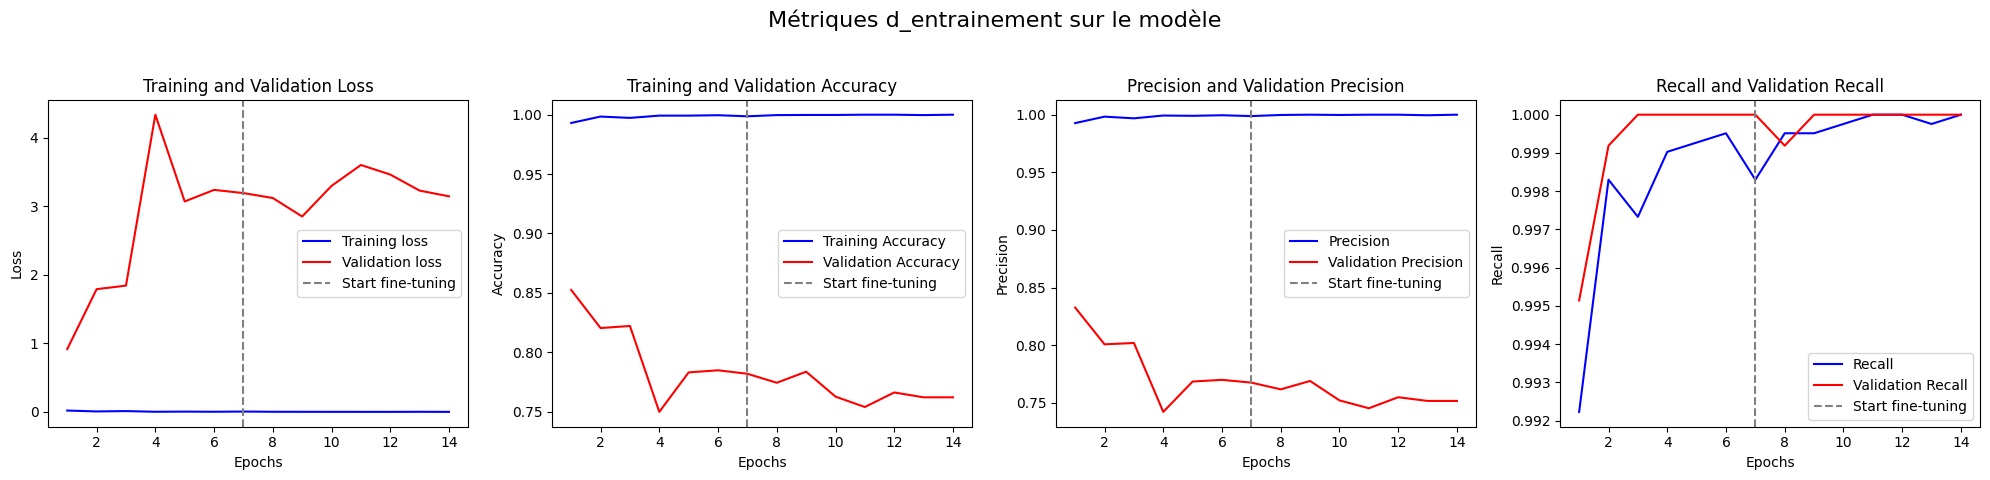

In [22]:
# Fusionner les deux phases pour les tracer ensemble
loss = history_tr.history["loss"] + history_fine.history["loss"]
acc = history_tr.history["accuracy"] + history_fine.history["accuracy"]
per = history_tr.history['Precision'] + history_fine.history['Precision']
recall = history_tr.history['Recall'] + history_fine.history['Recall']

val_loss = history_tr.history["val_loss"] + history_fine.history["val_loss"]
val_acc = history_tr.history["val_accuracy"] + history_fine.history["val_accuracy"]
val_per = history_tr.history['val_Precision'] + history_fine.history['val_Precision']
val_recall = history_tr.history['val_Recall'] + history_fine.history['val_Recall']

epochs = range(1, len(loss) + 1)
fine_tune_at = len(history_tr.history["loss"]) + 1

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Tracer la courbe de perte
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))

# Affichage des métriques de la perte

ax[0].plot(epochs, loss, 'b-', label='Training loss')
ax[0].plot(epochs, val_loss, 'r-', label='Validation loss')
ax[0].axvline(x=fine_tune_at, color='gray', linestyle='--', label='Start fine-tuning')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Affichage des métriques de accuracy

ax[1].plot(epochs, acc, 'b-', label='Training Accuracy')
ax[1].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
ax[1].axvline(x=fine_tune_at, color='gray', linestyle='--', label='Start fine-tuning')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Affichage des métriques de précision

ax[2].plot(Epochs, per, 'b-', label='Precision')
ax[2].plot(Epochs, val_per, 'r-', label='Validation Precision')
ax[2].axvline(x=fine_tune_at, color='gray', linestyle='--', label='Start fine-tuning')
ax[2].set_title('Precision and Validation Precision')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Precision')
ax[2].legend()

# Affichage des métriques de rappel

ax[3].plot(Epochs, recall, 'b-', label='Recall')
ax[3].plot(Epochs, val_recall, 'r-', label='Validation Recall')
ax[3].axvline(x=fine_tune_at, color='gray', linestyle='--', label='Start fine-tuning')
ax[3].set_title('Recall and Validation Recall')
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Recall')
ax[3].legend()

plt.suptitle('Métriques d_entrainement sur le modèle', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Loading best model for testing...
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step
Test Accuracy: 81.85%

Classification Report:

              precision    recall  f1-score   support

        Sain       0.96      0.43      0.60       405
      Tumeur       0.80      0.99      0.88       906

    accuracy                           0.82      1311
   macro avg       0.88      0.71      0.74      1311
weighted avg       0.85      0.82      0.79      1311



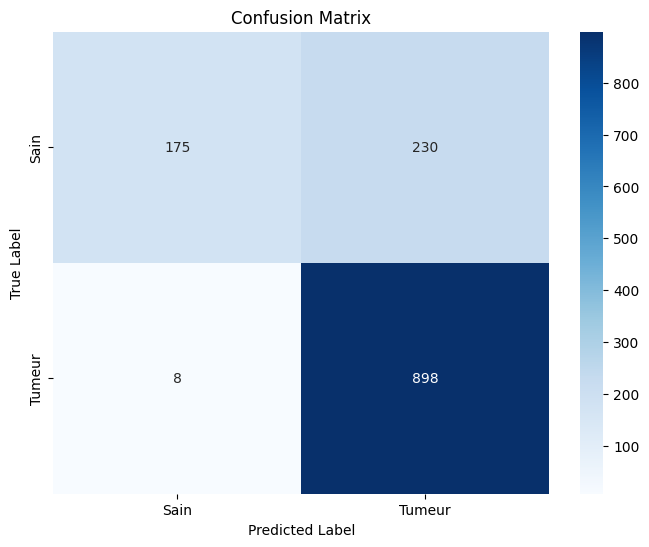

In [24]:
def test_model(model, test_datagen):
    # Charger les poids du meilleur modèle sauvegardé
    model.load_weights('./models/model_cnn_resnet50.keras')
    predictions = model.predict(test_datagen)
    # For a sigmoid output (binary), round to 0 or 1
    if predictions.shape[1] == 1:
        predicted_classes = (predictions > 0.5).astype(int).flatten()
    else:
        predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_datagen.classes # Corrected line: Access classes from the generator
    test_acc = 100 * np.sum(predicted_classes == true_classes) / len(true_classes)

    print(f"Test Accuracy: {test_acc:.2f}%\n")


    print("Classification Report:\n")
    print(classification_report(
        true_classes,
        predicted_classes,
        target_names=['Sain', 'Tumeur'],
        labels=[0, 1]
    ))

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sain', 'Tumeur'], yticklabels=['Sain', 'Tumeur']) # Corrected: Use explicit labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\nLoading best model for testing...")
try:
    cnn_model_resnet50
except NameError:
    print("Erreur : 'cnn_model' n'est pas défini. Veuillez vérifier l'entraînement du modèle.")
else:
    test_model(cnn_model_resnet50, test_datagen)

# 5-Prédiction

Poids du meilleur modèle chargés pour la visualisation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


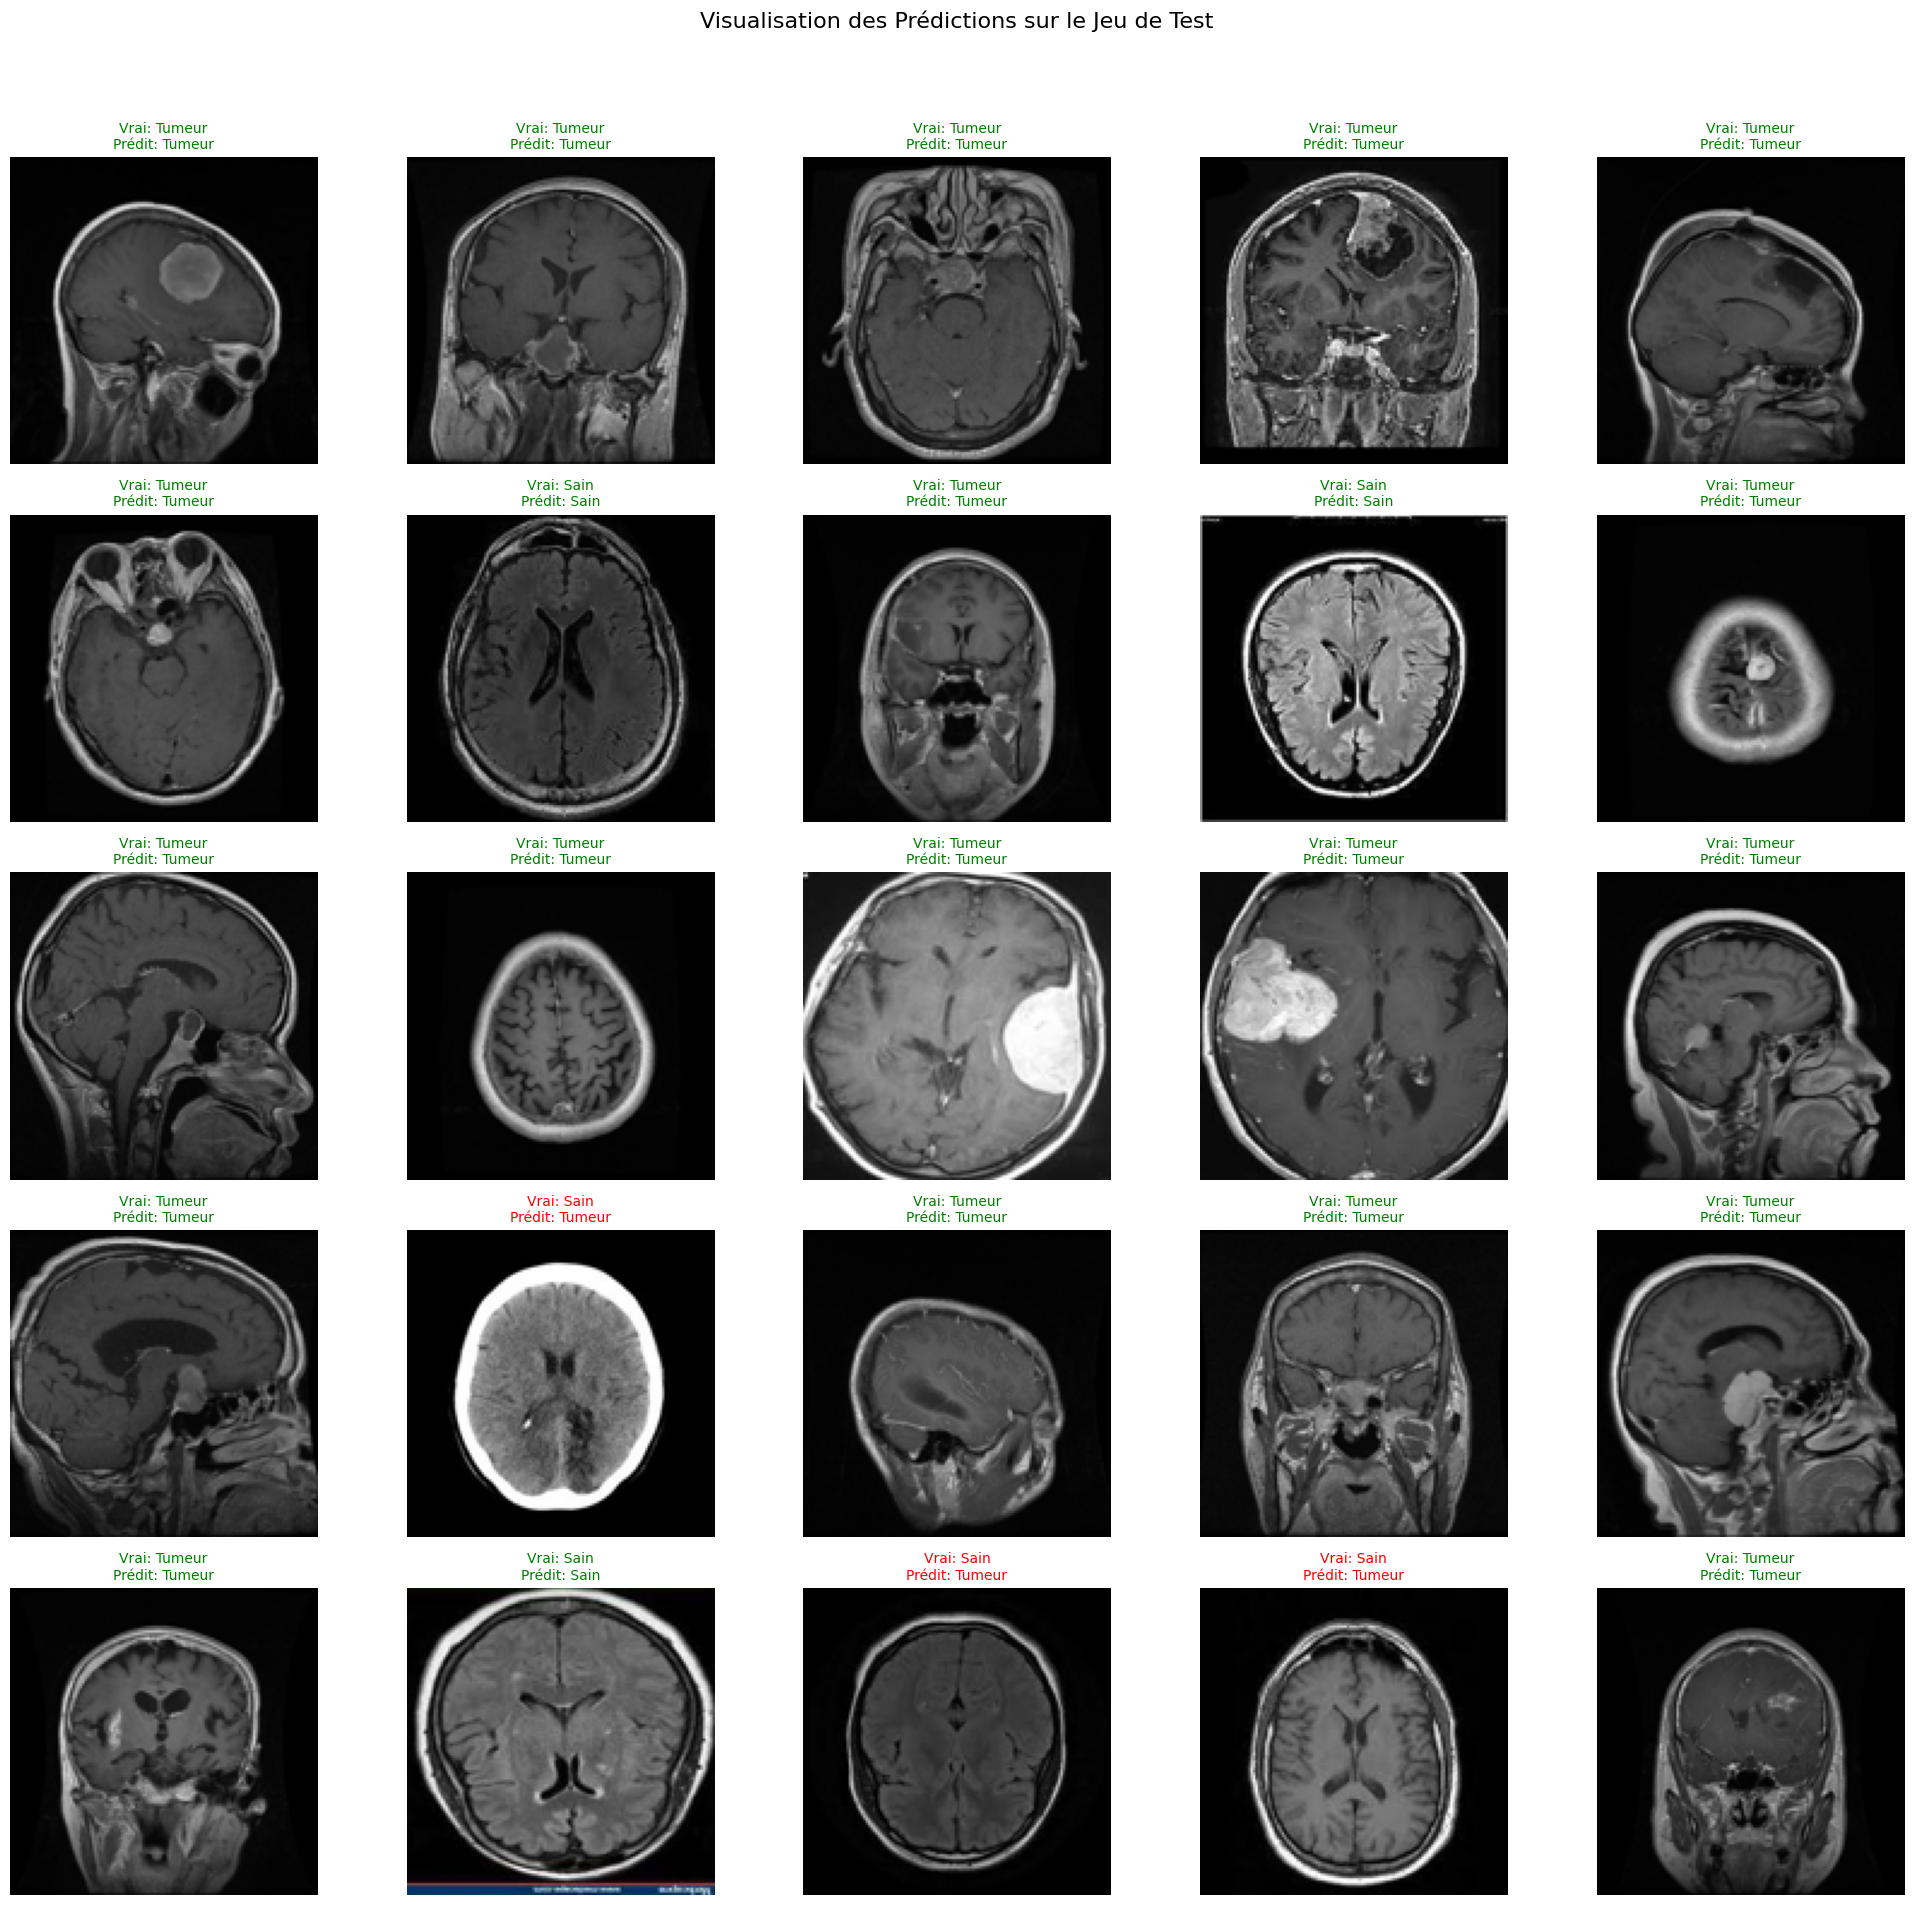

In [25]:
def display_predictions(model, test_generator, num_samples=25):
    """
    Affiche un échantillon d'images de test avec leurs vrais labels et les prédictions du modèle.
    """
    plt.figure(figsize=(20, 20))

    # S'assurer que num_samples n'est pas plus grand que le dataset
    num_samples = min(num_samples, len(test_generator.filepaths))

    # Sélectionner un échantillon aléatoire d'indices
    sample_indices = np.random.choice(len(test_generator.filepaths), size=num_samples, replace=False)

    # Récupérer les chemins et les vrais labels pour l'échantillon
    filepaths = np.array(test_generator.filepaths)[sample_indices]
    true_labels_indices = np.array(test_generator.classes)[sample_indices]

    # Charger les images originales en forçant la conversion en RGB pour la visualisation
    images_to_plot = np.array([np.array(Image.open(fp).convert('RGB').resize(params['image_size'])) for fp in filepaths])

    # Prétraiter les images pour le modèle et obtenir les prédictions
    # .copy() est important pour ne pas modifier les images originales
    preprocessed_images = preprocess_input(images_to_plot.copy())
    pred_probs = model.predict(preprocessed_images)

    # Convertir les probabilités en classes prédites (0 ou 1)
    predicted_labels_indices = (pred_probs > 0.5).astype(int).flatten()

    # Mapping des indices aux noms de classe ('Sain', 'Tumeur')
    idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
    true_labels = [idx_to_class[i] for i in true_labels_indices]
    predicted_labels = [idx_to_class[i] for i in predicted_labels_indices]

    rows = int(np.ceil(np.sqrt(num_samples)))
    cols = rows

    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        # Afficher l'image qui est maintenant garantie d'être en RGB
        plt.imshow(images_to_plot[i])

        true_label = true_labels[i]
        predicted_label = predicted_labels[i]

        color = "green" if true_label == predicted_label else "red"
        plt.title(f"Vrai: {true_label}\nPrédit: {predicted_label}", color=color, fontsize=10)
        plt.axis("off")

    plt.suptitle("Visualisation des Prédictions sur le Jeu de Test", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Appel de la fonction de visualisation ---
try:
    # S'assurer que le modèle est chargé (idéalement le meilleur modèle)
    model.load_weights('./models/model_cnn_resnet50.keras')
    print("Poids du meilleur modèle chargés pour la visualisation.")

    display_predictions(
        model=model,
        test_generator=test_datagen,
        num_samples=25
    )
except NameError:
    print("Erreur : 'model' n'est pas défini. Veuillez exécuter les cellules précédentes.")
except Exception as e:
    print(f"Une erreur est survenue lors de la visualisation : {e}")